In [1]:
# General Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from selenium import webdriver
import main
import seaborn as sns
import chromedriver_autoinstaller
from datetime import datetime
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
from matplotlib.colors import to_rgba
import matplotlib as mpl
from collections import defaultdict
import pickle
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
from PIL import Image
import urllib

In [2]:
chromedriver_autoinstaller.install()

import warnings
warnings.filterwarnings('ignore')

## Pull Data

In [3]:
chromedriver_autoinstaller.install()

if __name__ == "__main__":
    driver = webdriver.Chrome()
    
# whoscored match centre url of the required match (Example: Barcelona vs Sevilla)
url = "https://www.whoscored.com/Matches/1640737/Live/England-Premier-League-2022-2023-Fulham-Chelsea"
match_data = main.getMatchData(driver, url, close_window=True)

# Match dataframe containing info about the match
matches_df = main.createMatchesDF(match_data)

# Events dataframe      
events_df = main.createEventsDF(match_data)

# match Id
matchId = match_data['matchId']

# Information about respective teams as dictionary
home_data = matches_df['home'][matchId]
away_data = matches_df['away'][matchId]
score = matches_df['score'][matchId]
score = ' ' + score.replace(':', '-') + ' '

home_name = home_data['name']
away_name = away_data['name']
date = match_data['startDate'].split('T')[0]
date_ = datetime.strptime(date, '%Y-%m-%d').date()
date_str = date_.strftime('%d/%m/%Y')

Region: England, League: Premier League, Season: 2022/2023, Match Id: 1640737


In [4]:
homeID = home_data['teamId']
awayID = away_data['teamId']

## Colours 

In [5]:
home_color = '#9C9C9C'
away_color = '#2D5DE7'

## Get Passes 
- Then add a progressive column and filter all progressive passes (which we define as moving 25% closer to the goal)

In [6]:
df_passes = events_df[(events_df['teamId'] == awayID) & 
                      (events_df['type'] == 'Pass')].reset_index(drop=True)
df_passes['ProgPass'] = ''

for i in range(len(df_passes)):
    x_0 = 120*(df_passes['x'][i])/100
    y_0 = 80*(df_passes['y'][i])/100
    x_1 = 120*(df_passes['endX'][i])/100
    y_1 = 80*(df_passes['endY'][i])/100
    
    beg_dist = np.sqrt((120 - x_0)**2 + (40 - y_0)**2)
    end_dist = np.sqrt((120 - x_1)**2 + (40 - y_1)**2)

    if end_dist/beg_dist <= 0.75:
        df_passes['ProgPass'][i] = 1
    else:
        df_passes['ProgPass'][i] = 0
        

In [7]:
df_passes_prog = df_passes[df_passes['ProgPass'] == 1].reset_index(drop=True)
df_prog_away = df_passes_prog.copy()
df_passes_prog = df_passes_prog[['x', 'y', 'endX', 'endY', 'outcomeType']]
df_passes_prog

,x,y,endX,endY,outcomeType
0,22.8,2.3,53.5,5.0,Successful
1,52.5,2.6,90.5,8.6,Successful
2,93.0,25.1,89.9,46.7,Successful
3,37.6,88.8,56.7,83.4,Successful
4,33.7,10.7,72.8,39.1,Unsuccessful
...,...,...,...,...,...
86,18.2,39.8,57.5,94.4,Successful
87,18.9,49.0,61.5,22.0,Unsuccessful
88,23.0,84.2,68.7,53.0,Unsuccessful
89,32.8,96.9,63.6,71.0,Unsuccessful


In [8]:
np.array(df_passes_prog[['x', 'y', 'endX', 'endY']])

array([[ 22.8,   2.3,  53.5,   5. ],
       [ 52.5,   2.6,  90.5,   8.6],
       [ 93. ,  25.1,  89.9,  46.7],
       [ 37.6,  88.8,  56.7,  83.4],
       [ 33.7,  10.7,  72.8,  39.1],
       [ 11.2,  18.1,  51.8,  32.6],
       [ 87.1,   8.9,  94.7,  55.7],
       [ 18.4,  44.5,  47.6,  62.3],
       [  5.9,  67.8,  32.7,  70.4],
       [ 47.3,  15.1,  65.7,  23. ],
       [ 99.5,   0.5,  92.5,  53.1],
       [ 53.1,  15.1,  70. ,  23.3],
       [ 43. ,  76.5,  78.9,  45.1],
       [ 99.5,   0.5,  90.2,  55.2],
       [ 89.9,  80.4,  91. ,  62.1],
       [ 42.1,   0. ,  57.1,  21.1],
       [ 57.1,  21.1,  68.8,  39.2],
       [ 62.2,  86.9, 100. ,  15.7],
       [ 72.2,   0. , 100. ,  27.5],
       [ 11.8,  77. ,  48.6, 100. ],
       [  3.2,  71.7,  45.9,  88.5],
       [ 63. ,  53.9, 100. ,  81.8],
       [ 57.9,  48.1,  76.1,  64.2],
       [ 52.5,  56. ,  68.8,  65.9],
       [ 96.8,   2.6,  95.8,  43. ],
       [ 96.8,   0. ,  81.3,  28.9],
       [ 81.3,  28.9,  95.4,  50.9],
 

In [9]:
df_cluster = np.array(df_passes_prog[['x', 'y', 'endX', 'endY']])
wss = []
for k in range(1,20):
    kmeans = KMeans(n_clusters = k, random_state=100)
    kmeans.fit(df_cluster)
    wss.append(kmeans.inertia_)
    
mycenters = pd.DataFrame({'Clusters':range(1,20), 'WSS':wss})
mycenters

,Clusters,WSS
0,1,232983.167473
1,2,147964.948735
2,3,102971.980357
3,4,73989.639058
4,5,62350.061909
5,6,55015.294945
6,7,48816.965244
7,8,43405.019182
8,9,38436.730379
9,10,36417.762703


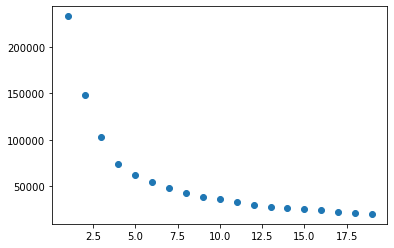

In [10]:
plt.scatter(x=mycenters['Clusters'], y=mycenters['WSS'])

# Guess 6/7 is the elbow - use that going forward

In [11]:
df_cluster = np.array(df_passes_prog[['x', 'y', 'endX', 'endY']])
kmeans = KMeans(n_clusters = 7, random_state = 100)
kmeans.fit(df_cluster)
df_passes_prog['cluster'] = kmeans.predict(df_cluster)

In [12]:
df_clusters = df_passes_prog.groupby('cluster')[['x', 'y', 'endX', 'endY']].mean().reset_index()
df_clusters

,cluster,x,y,endX,endY
0,0,90.281818,87.627273,94.781818,52.690909
1,1,25.321429,40.600000,63.885714,34.750000
2,2,43.368421,79.026316,71.773684,70.047368
3,3,88.736364,13.018182,92.818182,44.045455
4,4,53.754545,46.827273,75.863636,66.236364
5,5,16.080000,67.820000,45.020000,78.850000
6,6,38.626667,12.680000,63.960000,20.840000


In [13]:
indexes = sorted(df_passes_prog['cluster'].unique().tolist())
succ_rate = []
for idx in indexes:
    df = df_passes_prog[df_passes_prog['cluster'] == idx]
    succ = len(df[df['outcomeType'] == 'Successful'])
    fail = len(df[df['outcomeType'] == 'Unsuccessful'])
    rate = str(succ) + '/' + str(succ+fail)
    succ_rate.append(rate)

## For Home Team 

In [14]:
df_passes2 = events_df[(events_df['teamId'] == homeID) & 
                       (events_df['type'] == 'Pass')].reset_index(drop=True)
df_passes2['ProgPass'] = ''

for i in range(len(df_passes2)):
    x_0 = 120*(df_passes2['x'][i])/100
    y_0 = 80*(df_passes2['y'][i])/100
    x_1 = 120*(df_passes2['endX'][i])/100
    y_1 = 80*(df_passes2['endY'][i])/100
    
    beg_dist = np.sqrt((120 - x_0)**2 + (40 - y_0)**2)
    end_dist = np.sqrt((120 - x_1)**2 + (40 - y_1)**2)

    if end_dist/beg_dist <= 0.75:
        df_passes2['ProgPass'][i] = 1
    else:
        df_passes2['ProgPass'][i] = 0

df_passes_prog2 = df_passes2[df_passes2['ProgPass'] == 1].reset_index(drop=True)
df_prog_home = df_passes_prog2.copy()
df_passes_prog2 = df_passes_prog2[['x', 'y', 'endX', 'endY', 'outcomeType']]

df_cluster2 = np.array(df_passes_prog2[['x', 'y', 'endX', 'endY']])
kmeans.fit(df_cluster2)
df_passes_prog2['cluster'] = kmeans.predict(df_cluster2)
df_clusters2 = df_passes_prog2.groupby('cluster')[['x', 'y', 'endX', 'endY']].mean().reset_index()

indexes2 = sorted(df_passes_prog2['cluster'].unique().tolist())
succ_rate2 = []
for idx in indexes2:
    df = df_passes_prog2[df_passes_prog2['cluster'] == idx]
    succ = len(df[df['outcomeType'] == 'Successful'])
    fail = len(df[df['outcomeType'] == 'Unsuccessful'])
    rate = str(succ) + '/' + str(succ+fail)
    succ_rate2.append(rate)
succ_rate2

['8/19', '10/15', '1/8', '4/14', '6/10', '13/20', '3/14']

## Carries 

In [15]:
df_carries = pd.DataFrame()
min_len = 3
max_len = 60
min_time = 1
max_time = 12

for idx, match_event in events_df.iterrows():
    if idx == len(events_df) - 1:
        break
    
    cur_team = match_event['teamId']
    idx_next = idx + 1
    events_df_next = events_df.loc[idx_next]
    take_ons = 0
    loop = True
    count = 0 
    
    while loop:
        next_events = events_df.loc[idx_next]
        
        if next_events['type'] == 'TakeOn' and next_events['outcomeType'] == 'Successful':
            take_ons += 1
            loop = True
        
        elif (next_events['type'] == 'TakeOn' and next_events['outcomeType'] == 'Unsuccessful') or (next_events['teamId'] != cur_team and next_events['type'] == 'Challenge' and next_events['outcomeType'] == 'Unsuccessful') or (next_events['type'] == 'Foul'):
            loop = True
            
        else:
            loop = False
            
        idx_next += 1
        count += 0 
        

    same_team = cur_team == next_events['teamId']
    not_ball_touch = match_event['type'] != 'BallTouch'
    dx = 105 * (match_event['endX'] - next_events['x'])/100
    dy = 68 * (match_event['endY'] - next_events['y'])/100
    min_dist = dx**2 + dy**2 >= min_len**2
    max_dist = dx**2 + dy**2 <= max_len**2
    same_period = match_event['period'] == next_events['period']
    
    valid_carry = same_team & not_ball_touch & min_dist & max_dist & same_period 
    
    if valid_carry:
        carry = pd.DataFrame()
        prev = match_event
        nxt = next_events
        carry.loc[0, 'eventId'] = prev['eventId'] + count
        carry['id'] = prev['id'] + count
        carry['teamId'] = nxt['teamId']
        carry['x'] = prev['endX']
        carry['y'] = prev['endY']
        carry['period'] = nxt['period']
        carry['type'] = carry.apply(lambda x: {'value': 99, 'displayName': 'Carry'}, axis=1)
        carry['outcomeType'] = 'Successful'
        carry['qualifiers'] = carry.apply(
            lambda x: {'type': {'value': 999, 'displayName': 'takeOns'}, 'value': str(take_ons)}, axis=1)
        carry['satisfiedEventsTypes'] = carry.apply(lambda x: [], axis=1)
        carry['isTouch'] = True
        carry['playerId'] = nxt['playerId']
        carry['playerName'] = nxt['playerName']
        carry['endX'] = nxt['x']
        carry['endY'] = nxt['y']
        
        df_carries = pd.concat([df_carries, carry], ignore_index=True, sort=False)


In [16]:
df_carries1 = df_carries[(df_carries['teamId'] == awayID)].reset_index(drop=True)

df_carries1['ProgCarry'] = ''
for i in range(len(df_carries1)):
    x_0 = 120*(df_carries1['x'][i])/100
    y_0 = 80*(df_carries1['y'][i])/100
    x_1 = 120*(df_carries1['endX'][i])/100
    y_1 = 80*(df_carries1['endY'][i])/100
    
    beg_dist = np.sqrt((120 - x_0)**2 + (40 - y_0)**2)
    end_dist = np.sqrt((120 - x_1)**2 + (40 - y_1)**2)

    if end_dist/beg_dist <= 0.75:
        df_carries1['ProgCarry'][i] = 1
    else:
        df_carries1['ProgCarry'][i] = 0
        
# prog_carries = pd.DataFrame(df_carries.groupby('playerName')['ProgCarry'].sum()).reset_index()
df_carries1 = df_carries1[df_carries1['ProgCarry'] == 1].reset_index(drop=True)
df_prog_carries_away = df_carries1.copy()
df_carries1 = df_carries1[['x', 'y', 'endX', 'endY']]
df_carries1

,x,y,endX,endY
0,90.5,8.6,93.0,25.1
1,76.1,64.2,85.5,63.8
2,71.8,97.1,72.9,72.3
3,92.2,54.2,95.6,53.8
4,48.3,59.4,65.4,45.2
5,83.3,3.4,97.2,30.8
6,78.7,91.7,88.3,85.2
7,38.1,71.6,88.5,87.8
8,62.5,94.7,77.2,85.7
9,77.3,74.1,95.0,68.9


In [17]:
carry_cluster = np.array(df_carries1[['x', 'y', 'endX', 'endY']])
kmeans_carry = KMeans(n_clusters = 3, random_state = 100)
kmeans_carry.fit(carry_cluster)
df_carries1['cluster'] = kmeans_carry.predict(carry_cluster)
df_clusters3 = df_carries1.groupby('cluster')[['x', 'y', 'endX', 'endY']].mean().reset_index()
df_clusters3

,cluster,x,y,endX,endY
0,0,86.9000,6.000,95.100,27.950
1,1,75.7625,80.150,86.600,69.300
2,2,43.3750,59.475,69.575,64.725


In [18]:
indexes3 = sorted(df_carries1['cluster'].unique().tolist())
succ_rate3 = []
for idx in indexes3:
    df = df_carries1[df_carries1['cluster'] == idx]
    num = len(df)
    succ_rate3.append(str(num))
succ_rate3

['2', '8', '4']

## For Home Team 

In [19]:
df_carries2 = df_carries[(df_carries['teamId'] == homeID)].reset_index(drop=True)

df_carries2['ProgCarry'] = ''
for i in range(len(df_carries2)):
    x_0 = 120*(df_carries2['x'][i])/100
    y_0 = 80*(df_carries2['y'][i])/100
    x_1 = 120*(df_carries2['endX'][i])/100
    y_1 = 80*(df_carries2['endY'][i])/100
    
    beg_dist = np.sqrt((120 - x_0)**2 + (40 - y_0)**2)
    end_dist = np.sqrt((120 - x_1)**2 + (40 - y_1)**2)

    if end_dist/beg_dist <= 0.75:
        df_carries2['ProgCarry'][i] = 1
    else:
        df_carries2['ProgCarry'][i] = 0
        
# prog_carries = pd.DataFrame(df_carries.groupby('playerName')['ProgCarry'].sum()).reset_index()
df_carries2 = df_carries2[df_carries2['ProgCarry'] == 1].reset_index(drop=True)
df_prog_carries_home = df_carries2.copy()
df_carries2 = df_carries2[['x', 'y', 'endX', 'endY']]


carry_cluster = np.array(df_carries2[['x', 'y', 'endX', 'endY']])
kmeans_carry = KMeans(n_clusters = 3, random_state = 100)
kmeans_carry.fit(carry_cluster)
df_carries2['cluster'] = kmeans_carry.predict(carry_cluster)
df_clusters4 = df_carries2.groupby('cluster')[['x', 'y', 'endX', 'endY']].mean().reset_index()

indexes4 = sorted(df_carries2['cluster'].unique().tolist())
succ_rate4 = []
for idx in indexes4:
    df = df_carries2[df_carries2['cluster'] == idx]
    num = len(df)
    succ_rate4.append(str(num))
succ_rate4

['4', '1', '1']

## Top 3 Prog Passes

In [20]:
# Attempted
df_prog_attempt_home = pd.DataFrame(df_prog_home.groupby('playerName')['x'].count()).reset_index().sort_values(by='x', ascending=False)[:3].reset_index(drop=True)

# Successful
df_prog_succ_home = df_prog_home[df_prog_home['outcomeType'] == 'Successful'].reset_index(drop=True)
df_prog_succ_home = pd.DataFrame(df_prog_succ_home.groupby('playerName')['x'].count()).reset_index().sort_values(by='x', ascending=False)[:3].reset_index(drop=True)


# For Away Team

# Attempted
df_prog_attempt_away = pd.DataFrame(df_prog_away.groupby('playerName')['x'].count()).reset_index().sort_values(by='x', ascending=False)[:3].reset_index(drop=True)

# Successful
df_prog_succ_away = df_prog_away[df_prog_away['outcomeType'] == 'Successful'].reset_index(drop=True)
df_prog_succ_away = pd.DataFrame(df_prog_succ_away.groupby('playerName')['x'].count()).reset_index().sort_values(by='x', ascending=False)[:3].reset_index(drop=True)

In [21]:
df_prog_attempt_away

,playerName,x
0,Kalidou Koulibaly,14
1,Thiago Silva,13
2,Mateo Kovacic,11


## Top 3 Prog Carries 

In [22]:
# For Home Team
df_prog_carry_home = pd.DataFrame(df_prog_carries_home.groupby('playerName')['x'].count()).reset_index().sort_values(by='x', ascending=False).reset_index(drop=True)[:3]

# For Away Team
df_prog_carry_away = pd.DataFrame(df_prog_carries_away.groupby('playerName')['x'].count()).reset_index().sort_values(by='x', ascending=False).reset_index(drop=True)[:3]
df_prog_carry_away

,playerName,x
0,João Félix,3
1,Kai Havertz,3
2,Lewis Hall,2


## Pass Field Gains 

In [23]:
home_passes = events_df[(events_df['teamId'] == homeID) & 
                        (events_df['type'] == 'Pass') & 
                        (events_df['outcomeType'] == 'Successful')].reset_index(drop=True)[['playerName', 'x', 'y', 'endX', 'endY']]
home_passes['startDist'] = ''
home_passes['endDist'] = ''

for i in range(len(home_passes)):
    x0 = home_passes['x'][i]
    x1 = home_passes['endX'][i]
    y0 = home_passes['y'][i]
    y1 = home_passes['endY'][i]
    
    startDist = np.sqrt((100 - x0)**2 + (50 - y0)**2)
    endDist = np.sqrt((100 - x1)**2 + (50 - y1)**2)
    
    home_passes['startDist'][i] = startDist
    home_passes['endDist'][i] = endDist
    
home_passes['changeDist'] = home_passes['endDist'] - home_passes['startDist']
fwd_passes = home_passes[home_passes['changeDist'] < 0].reset_index(drop=True)
fwd_passes['changeDist'] = abs(fwd_passes['changeDist'])
fwd_passes['pctTwdGoal'] = fwd_passes['changeDist'] / fwd_passes['startDist']
home_field_gains_pass = pd.DataFrame(fwd_passes.groupby('playerName')['pctTwdGoal'].sum()).reset_index().sort_values(by='pctTwdGoal', ascending=False).reset_index(drop=True)[:3]
home_field_gains_pass


# For Away Team
away_passes = events_df[(events_df['teamId'] == awayID) & 
                        (events_df['type'] == 'Pass') & 
                        (events_df['outcomeType'] == 'Successful')].reset_index(drop=True)[['playerName', 'x', 'y', 'endX', 'endY']]
away_passes['startDist'] = ''
away_passes['endDist'] = ''

for i in range(len(away_passes)):
    x0 = away_passes['x'][i]
    x1 = away_passes['endX'][i]
    y0 = away_passes['y'][i]
    y1 = away_passes['endY'][i]
    
    startDist = np.sqrt((100 - x0)**2 + (50 - y0)**2)
    endDist = np.sqrt((100 - x1)**2 + (50 - y1)**2)
    
    away_passes['startDist'][i] = startDist
    away_passes['endDist'][i] = endDist
    
away_passes['changeDist'] = away_passes['endDist'] - away_passes['startDist']
fwd_passes2 = away_passes[away_passes['changeDist'] < 0].reset_index(drop=True)
fwd_passes2['changeDist'] = abs(fwd_passes2['changeDist'])
fwd_passes2['pctTwdGoal'] = fwd_passes2['changeDist'] / fwd_passes2['startDist']
away_field_gains_pass = pd.DataFrame(fwd_passes2.groupby('playerName')['pctTwdGoal'].sum()).reset_index().sort_values(by='pctTwdGoal', ascending=False).reset_index(drop=True)[:3]
away_field_gains_pass

,playerName,pctTwdGoal
0,Kalidou Koulibaly,5.954833
1,Mateo Kovacic,4.912296
2,César Azpilicueta,3.672374


## Carry Field Gains 

In [24]:
# Home Team
home_carries = df_carries[df_carries['teamId'] == homeID].reset_index(drop=True)

home_carries['startDist'] = ''
home_carries['endDist'] = ''

for i in range(len(home_carries)):
    x0 = home_carries['x'][i]
    x1 = home_carries['endX'][i]
    y0 = home_carries['y'][i]
    y1 = home_carries['endY'][i]
    
    startDist = np.sqrt((100 - x0)**2 + (50 - y0)**2)
    endDist = np.sqrt((100 - x1)**2 + (50 - y1)**2)
    
    home_carries['startDist'][i] = startDist
    home_carries['endDist'][i] = endDist
    
home_carries['changeDist'] = home_carries['endDist'] - home_carries['startDist']
fwd_carries = home_carries[home_carries['changeDist'] < 0].reset_index(drop=True)
fwd_carries['changeDist'] = abs(fwd_carries['changeDist'])
fwd_carries['pctTwdGoal'] = fwd_carries['changeDist'] / fwd_carries['startDist']
home_field_gains_carries = pd.DataFrame(fwd_carries.groupby('playerName')['pctTwdGoal'].sum()).reset_index().sort_values(by='pctTwdGoal', ascending=False).reset_index(drop=True)[:3]
home_field_gains_carries


# Away Team
away_carries = df_carries[df_carries['teamId'] == awayID].reset_index(drop=True)

away_carries['startDist'] = ''
away_carries['endDist'] = ''

for i in range(len(away_carries)):
    x0 = away_carries['x'][i]
    x1 = away_carries['endX'][i]
    y0 = away_carries['y'][i]
    y1 = away_carries['endY'][i]
    
    startDist = np.sqrt((100 - x0)**2 + (50 - y0)**2)
    endDist = np.sqrt((100 - x1)**2 + (50 - y1)**2)
    
    away_carries['startDist'][i] = startDist
    away_carries['endDist'][i] = endDist
    
away_carries['changeDist'] = away_carries['endDist'] - away_carries['startDist']
fwd_carries = away_carries[away_carries['changeDist'] < 0].reset_index(drop=True)
fwd_carries['changeDist'] = abs(fwd_carries['changeDist'])
fwd_carries['pctTwdGoal'] = fwd_carries['changeDist'] / fwd_carries['startDist']
away_field_gains_carries = pd.DataFrame(fwd_carries.groupby('playerName')['pctTwdGoal'].sum()).reset_index().sort_values(by='pctTwdGoal', ascending=False).reset_index(drop=True)[:3]
away_field_gains_carries


,playerName,pctTwdGoal
0,Kai Havertz,1.878129
1,Mateo Kovacic,1.638747
2,João Félix,1.580198


## Plot

In [25]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
from matplotlib.colors import to_rgba
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import matplotlib.colors
mpl.rcParams['figure.dpi'] = 800

FIGWIDTH, FIGHEIGHT = 14, 10
FIGSIZE = (FIGWIDTH, FIGHEIGHT)
FIG_ASPECT = FIGWIDTH / FIGHEIGHT
fig = plt.figure(figsize=FIGSIZE)

pitch1 = VerticalPitch(pitch_type='opta', pitch_color='#2B2B2B', line_color='#c7d5cc', pad_left = 40,
                       line_zorder=2, pad_bottom=20, pad_right=5,   linewidth=0.6, pitch_length=5, pad_top=30)
pitch2 = VerticalPitch(pitch_type='opta', pitch_color='#2B2B2B', line_color='#c7d5cc', pad_right = 40,
                       line_zorder=2,  pad_bottom=20, pad_left=5,  linewidth=0.6, pitch_length=5, pad_top=30)

fig.set_facecolor("#2B2B2B")

TITLE_HEIGHT = 0.1 # title axes are 10% of the figure height

#  width of pitch axes as percent of the figure width
TOP_WIDTH = 0.48
BOTTOM_WIDTH = 0.25

# calculate the horizontal space between axes (and figure sides) in percent of the figure width
TOP_SPACE = (1 - (TOP_WIDTH * 2)) / 2
BOTTOM_SPACE = (1 - (BOTTOM_WIDTH * 3)) / 2

# calculate the height of the pitch axes in percent of the figure height
height1 = (TOP_WIDTH / pitch1.ax_aspect * FIG_ASPECT)
height2 = (TOP_WIDTH / pitch2.ax_aspect * FIG_ASPECT)


# calculate pitch offsets from center / title locations
vertical_axes_space = (1 - (height1 + TITLE_HEIGHT + TITLE_HEIGHT)) / 5
bottom_offset = ((1 - height2) / 2) - vertical_axes_space
title1_bottom = 1 - vertical_axes_space - TITLE_HEIGHT
title2_bottom = 1 - (vertical_axes_space * 3) - (TITLE_HEIGHT * 2) - height1
top_offset = (1 - title1_bottom - title2_bottom - TITLE_HEIGHT) / 2



# top left
LEFT1 = TOP_SPACE
bottom1 = (1 - height1) / 2 - top_offset
ax1 = fig.add_axes((LEFT1, bottom1, TOP_WIDTH, height1))
pitch1.draw(ax=ax1)

# top right
left2 = (TOP_SPACE ) + (TOP_WIDTH)
bottom2 = (1 - height2) / 2 - top_offset
ax2 = fig.add_axes((left2, bottom2, TOP_WIDTH, height2))
pitch2.draw(ax=ax2)

ax_title2 = fig.add_axes((0, title1_bottom-0.05, 1, TITLE_HEIGHT-0.05))
ax_title2.axis('off')
ax_title2.text(left2 ,0.45,
               f'{home_name} {score} { away_name}'.upper(),
               color='white', size=13, va='center', ha='center', fontname = 'Sans Serif')
ax_title2.text(left2 ,1.1,
               'Progressive Action Clusters'.upper(),
               color='white', size=18, va='center', ha='center', fontname = 'Sans Serif')
ax_title2.text(left2 ,-0.15,
               f'{date_str}  |  CREATED BY ...',
               color='white', size=13, va='center', ha='center', fontname = 'Sans Serif')


pitch1.annotate(text=home_name.upper(), 
                          xytext=(102, 100), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 15, ax = ax1)

pitch2.annotate(text=away_name.upper(), 
                          xytext=(102, 0), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 15, ax = ax2)

for index, row in df_clusters.iterrows():
    pitch2.arrows(df_clusters.x, df_clusters.y,
                  df_clusters.endX, df_clusters.endY, lw=0.5,
                  color=away_color, zorder=1, ax=ax2, headlength=2, headwidth=3, headaxislength=2)
    x = float(df_clusters.x[index])
    y = float(df_clusters.y[index])
    pitch2.annotate(text=str(succ_rate[index]), 
                    bbox=dict(facecolor=away_color, edgecolor='#2B2B2B', boxstyle='round,pad=.2', alpha=1),
                    xytext=(x, y), xy=(60, 40), ha='center', va='center',
                    fontname = 'Sans Serif', fontsize=12, color='white', ax=ax2)
    


for index, row in df_clusters2.iterrows():
    pitch1.arrows(df_clusters2.x, df_clusters2.y,
                  df_clusters2.endX, df_clusters2.endY, lw=0.5,
                  color=home_color, zorder=1, ax=ax1, headlength=2, headwidth=3, headaxislength=2)
    x = float(df_clusters2.x[index])
    y = float(df_clusters2.y[index])
    pitch1.annotate(text=str(succ_rate2[index]), 
                    bbox=dict(facecolor=home_color, edgecolor='#2B2B2B', boxstyle='round,pad=.2', alpha=1),
                    xytext=(x, y), xy=(60, 40), ha='center', va='center',
                    fontname = 'Sans Serif', fontsize=12, color='white', ax=ax1)
    
    

for index, row in df_clusters3.iterrows():
    pitch2.arrows(df_clusters3.x, df_clusters3.y,
                  df_clusters3.endX, df_clusters3.endY, lw=0.5, 
                  color='white', zorder=1, ax=ax2, headlength=2, headwidth=3, headaxislength=2)
    x = float(df_clusters3.x[index])
    y = float(df_clusters3.y[index])
    pitch2.annotate(text=str(succ_rate3[index]), 
                    bbox=dict(facecolor='white', edgecolor='#2B2B2B', boxstyle='round,pad=.2', alpha=1),
                    xytext=(x, y), xy=(60, 40), ha='center', va='center',
                    fontname = 'Sans Serif', fontsize=12, color='black', ax=ax2)
    
    

for index, row in df_clusters4.iterrows():
    pitch1.arrows(df_clusters4.x, df_clusters4.y,
                  df_clusters4.endX, df_clusters4.endY, lw=0.5, 
                  color='white', zorder=1, ax=ax1, headlength=2, headwidth=3, headaxislength=2)
    x = float(df_clusters4.x[index])
    y = float(df_clusters4.y[index])
    pitch1.annotate(text=str(succ_rate4[index]), 
                    bbox=dict(facecolor='white', edgecolor='#2B2B2B', boxstyle='round,pad=.2', alpha=1),
                    xytext=(x, y), xy=(60, 40), ha='center', va='center',
                    fontname = 'Sans Serif', fontsize=12, color='black', ax=ax1)
    
    
pitch1.arrows(-3, 100, -3, 80, lw=0.5, color=home_color, zorder=1, ax=ax1,
             headlength=2, headwidth=3, headaxislength=2)
pitch1.annotate(text='Progressive Pass'.upper(), 
                          xytext=(-3, 78), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 9, ax = ax1)
pitch1.arrows(-6, 100, -6, 80, lw=0.5, color='white', zorder=1, ax=ax1,
             headlength=2, headwidth=3, headaxislength=2)
pitch1.annotate(text='Progressive Carry'.upper(), 
                          xytext=(-6, 78), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 9, ax = ax1)



pitch2.arrows(-3, 100, -3, 80, lw=0.5, color=away_color, zorder=1, ax=ax2,
             headlength=2, headwidth=3, headaxislength=2)
pitch2.annotate(text='Progressive Pass'.upper(), 
                          xytext=(-3, 78), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 9, ax = ax2)
pitch2.arrows(-6, 100, -6, 80, lw=0.5, color='white', zorder=1, ax=ax2,
             headlength=2, headwidth=3, headaxislength=2)
pitch2.annotate(text='Progressive Carry'.upper(), 
                          xytext=(-6, 78), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 9, ax = ax2)


fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
team_logos2 = 9879
club_icon2 = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_logos2:.0f}.png'))
newax2 = fig.add_axes([0.025, 0.85, 0.1, 0.1], anchor='NE', zorder=2)
newax2.imshow(club_icon2)
newax2.axis('off')

fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
team_logos = 8455
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_logos:.0f}.png'))
newax = fig.add_axes([0.85, 0.85, 0.1, 0.1], anchor='NE', zorder=2)
newax.imshow(club_icon)
newax.axis('off')



pitch1.annotate(text='      Prog Pass Att     '.upper(), xytext=(98, 120), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax=ax1)

y = 95
i = 0
for p1, cnt in zip(df_prog_attempt_home['playerName'], df_prog_attempt_home['x']):
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch1.annotate(text=p1.upper(), 
                          xytext=(y-2*i, 134), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax1)
    pitch1.annotate(text=cnt, 
                          xytext=(y-2*i, 106), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax1)
    
    i += 1


pitch1.annotate(text='  Succ Prog Passes  '.upper(), xytext=(83, 120), xy=(60, 40), ha='center', 
                     va='center', color='white',
                     bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax=ax1)

y = 80
i = 0
for p1, cnt in zip(df_prog_succ_home['playerName'], df_prog_succ_home['x']):
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch1.annotate(text=p1.upper(), 
                          xytext=(y-2*i, 134), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax1)
    pitch1.annotate(text=cnt, 
                          xytext=(y-2*i, 106), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax1)
    
    i += 1

pitch1.annotate(text='       Prog Carries     '.upper(), xytext=(68, 120), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax=ax1)
y = 65
i = 0
for p1, cnt in zip(df_prog_carry_home['playerName'], df_prog_carry_home['x']):
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch1.annotate(text=p1.upper(), 
                          xytext=(y-2*i, 134), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax1)
    pitch1.annotate(text=str(cnt), 
                          xytext=(y-2*i, 106), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax1)
    
    i += 1
    
pitch1.annotate(text='  Pass Fields Gained '.upper(), xytext=(53, 120), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax=ax1)
y = 50
i = 0
for p1, cnt in zip(home_field_gains_pass['playerName'], home_field_gains_pass['pctTwdGoal']):
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    cnt = round(cnt,2)
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch1.annotate(text=p1.upper(), 
                          xytext=(y-2*i, 134), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax1)
    pitch1.annotate(text=cnt, 
                          xytext=(y-2*i,106), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax1)
    i+=1


pitch1.annotate(text='Carry Fields Gained'.upper(), xytext=(38, 120), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax=ax1)
y = 35
i = 0
for p1, cnt in zip(home_field_gains_carries['playerName'], home_field_gains_carries['pctTwdGoal']):
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    cnt = round(cnt,2)
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch1.annotate(text=p1.upper(), 
                          xytext=(y-2*i, 134), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax1)
    pitch1.annotate(text=cnt, 
                          xytext=(y-2*i,106), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax1)
    i+=1

    
    
pitch2.annotate(text='      Prog Pass Att     '.upper(), xytext=(98, -20), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=away_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax=ax2)

y = 95
i = 0
for p1, cnt in zip(df_prog_attempt_away['playerName'], df_prog_attempt_away['x']):
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch2.annotate(text=p1.upper(), 
                          xytext=(y-2*i, -6), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax2)
    pitch2.annotate(text=cnt, 
                          xytext=(y-2*i, -34), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax2)
    
    i += 1



pitch2.annotate(text='  Succ Prog Passes  '.upper(), xytext=(83, -20), xy=(60, 40), ha='center', 
                     va='center', color='white',
                     bbox=dict(facecolor=away_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax=ax2)

y = 80
i = 0
for p1, cnt in zip(df_prog_succ_away['playerName'], df_prog_succ_away['x']):
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch2.annotate(text=p1.upper(), 
                          xytext=(y-2*i, -6), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax2)
    pitch2.annotate(text=cnt, 
                          xytext=(y-2*i, -34), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax2)
    
    i += 1

pitch2.annotate(text='       Prog Carries     '.upper(), xytext=(68, -20), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=away_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax=ax2)
y = 65
i = 0
for p1, cnt in zip(df_prog_carry_away['playerName'], df_prog_carry_away['x']):
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch2.annotate(text=p1.upper(), 
                          xytext=(y-2*i, -6), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax2)
    pitch2.annotate(text=str(cnt), 
                          xytext=(y-2*i, -34), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax2)
    
    i += 1
    
pitch2.annotate(text='  Pass Fields Gained '.upper(), xytext=(53, -20), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=away_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax=ax2)
y = 50
i = 0
for p1, cnt in zip(away_field_gains_pass['playerName'], away_field_gains_pass['pctTwdGoal']):
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    cnt = round(cnt,2)
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch2.annotate(text=p1.upper(), 
                          xytext=(y-2*i, -6), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax2)
    pitch2.annotate(text=cnt, 
                          xytext=(y-2*i,-34), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax2)
    
    i += 1
    
pitch2.annotate(text='Carry Fields Gained'.upper(), xytext=(38, -20), xy=(60, 40), ha='center', va='center', color='white',
                     bbox=dict(facecolor=away_color, edgecolor='none', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=8, ax=ax2)
y = 35
i = 0
for p1, cnt in zip(away_field_gains_carries['playerName'], away_field_gains_carries['pctTwdGoal']):
    p1 = p1.replace('-', ' ')
    p1 = p1.split(' ')
    cnt = round(cnt,2)
    if len(p1) > 2:
        name = "".join([x[0].upper() for x in p1])
        p1 = name
    elif len(p1) == 1:
        p1 = p1[0]
    else:
        p1 = p1[1]
    pitch2.annotate(text=p1.upper(), 
                          xytext=(y-2*i, -6), xy=(20, 40), ha='left', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax2)
    pitch2.annotate(text=cnt, 
                          xytext=(y-2*i,-34), xy=(20, 40), ha='right', va='center', 
                          color='white', fontname = 'Sans Serif', fontsize = 6, ax=ax2)
    
    i+=1

pitch1.annotate(xytext=(-3.5, 26),xy = (20,40),
                text = '> Fields gained based on \n   @SaturdayOnCouch',
                color='#c7d5cc',
                va='center', ha='left', fontsize=7, fontname = 'Sans Serif', ax=ax1)    

fig.savefig('ProgClusters.png', 
            bbox_inches="tight",
            edgecolor="none",
            dpi=600)